# ML7 Практика

Наша практика будет основана на соревновании Kaggle: Predicting a Biological Response (Прогнозирование биологического ответа).

Необходимо предсказать биологический ответ молекул (столбец '`Activity`') по их химическому составу (столбцы `D1-D1776`).

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец `Activity` содержит экспериментальные данные, описывающие фактический биологический ответ `[0, 1]`; 
Остальные столбцы `D1-D1776` представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать `F1-score`.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (`GridSeachCV`, `RandomizedSearchCV`, `Hyperopt`, `Optuna`) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [24]:
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn import ensemble
from sklearn import model_selection
from sklearn import metrics


import seaborn as sns

Загружаем данные

In [4]:
data = pd.read_csv('data/_train_sem09__1_.zip')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Проверяем наличие пропусков

In [8]:
data.isna().sum().sum()

0

Смотрим на сбалансированность классов

<Axes: xlabel='Activity', ylabel='count'>

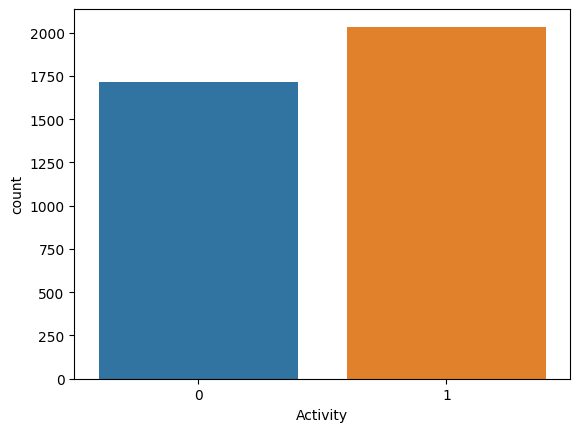

In [10]:
sns.countplot(data=data, x='Activity')

**Вывод**: классы довольно сбалансированны.

Создаём матрицу наблюдений и вектор ответов

In [13]:
X = data.drop(columns='Activity')
y = data['Activity']

Разделяем выборку на тренировочную и тестовую. Хоть выборка и более менее сбалансирована, всё равно проведём стратифицированное разбиение для чистоты эксперименты.

In [18]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('TRAIN shapes: ', X_train.shape, y_train.shape)
print('TEST shapes: ', X_test.shape, y_test.shape)

TRAIN shapes:  (3000, 1776) (3000,)
TEST shapes:  (751, 1776) (751,)


### <center> **GridSearchCV**

### LogisticRegression

In [26]:
param_grid_lr = [
    {'penalty': ['l2', 'None'],
     'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
     'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
    
    {'penalty': ['l1', 'l2'],
     'solver': ['liblinear'],
     'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
    
    {'penalty': ['elasticnet', 'l1', 'l2', 'None'],
     'solver': ['saga'],
     'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

grid_search_lr = model_selection.GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42,
        max_iter=1000
    ),
    param_grid=param_grid_lr,
    cv=5,
    n_jobs=-1
)

%time grid_search.fit(X_train, y_train)
y_test_gs_pred = grid_search_lr.predict(X_test)
print(f'F1 на тестовом наборе: {metrics.f1_score(y_true=y_test, y_pred=y_test_gs_pred):.2f}')
print(f'лучшие значения гиперпараметров: {grid_search_lr.best_params_}')
print(f'лучшая модель:\n{grid_search_lr.best_estimator_}')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

CPU times: user 1.18 s, sys: 290 ms, total: 1.47 s
Wall time: 4min 31s
F1 на тестовом наборе: 0.78
лучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}
лучшая модель:
LogisticRegression(C=0.3, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')


### RandomForest

In [29]:
param_grid_rf = {
    'n_estimators': [5, 10, 30, 50, 70, 100, 120, 140, 160, 180, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 3, 5, 8, 13, 21],
    'min_samples_leaf': [2, 3, 5, 8, 13, 21, 34]
}

grid_search_rf = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1
)

%time grid_search_rf.fit(X_train, y_train)
y_test_gs_pred = grid_search_rf.predict(X_test)
print(f'F1 на тестовом наборе: {metrics.f1_score(y_true=y_test, y_pred=y_test_gs_pred):.2f}')
print(f'лучшие значения гиперпараметров: {grid_search_rf.best_params_}')
print(f'лучшая модель:\n{grid_search_rf.best_estimator_}')

### <center> **RandomizedSearchCV**

### LogisticRegression

In [ ]:
param_distr_lr = [
    {'penalty': ['l2', 'None'],
     'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
     'C': list(np.linspace(0.01, 1, 10, dtype=float))},
    
    {'penalty': ['l1', 'l2'],
     'solver': ['liblinear'],
     'C': list(np.linspace(0.01, 1, 10, dtype=float))},
    
    {'penalty': ['elasticnet', 'l1', 'l2', 'None'],
     'solver': ['saga'],
     'C': list(np.linspace(0.01, 1, 10, dtype=float))}
]

random_search_lr = model_selection.RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000),
    param_distributions=param_distr_lr,
    cv=5,
    n_iter=10,
    n_jobs=-1
)

%time random_search_lr.fit(X_train, y_train)
y_test_rs_pred = random_search_lr.predict(X_test)
print(f'F1 на тестовом наборе: {metrics.f1_score(y_true=y_test, y_pred=y_test_rs_pred):.2f}')
print(f'лучшие значения гиперпараметров: {random_search_lr.best_params_}')
print(f'лучшая модель:\n{random_search_lr.best_estimator_}')

### RandomForest

In [ ]:
param_grid_rf = {
    'n_estimators': list(np.linspace(2, 300, 5)),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 3, 5, 8, 13, 21],
    'min_samples_leaf': [2, 3, 5, 8, 13, 21, 34]
}

grid_search_rf = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1
)

%time grid_search_rf.fit(X_train, y_train)
y_test_gs_pred = grid_search_rf.predict(X_test)
print(f'F1 на тестовом наборе: {metrics.f1_score(y_true=y_test, y_pred=y_test_gs_pred):.2f}')
print(f'лучшие значения гиперпараметров: {grid_search_rf.best_params_}')
print(f'лучшая модель:\n{grid_search_rf.best_estimator_}')